<a href="https://colab.research.google.com/github/Rivi9/Laptop-Recommendation-System/blob/NLP-Model/Text_Classification_NewModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Text Classification - FastText**

#### Install necessary libraries

In [ ]:
pip install fasttext

#### Import necessary libraries

In [ ]:
import re
import nltk
import fasttext
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#### Download necessary NLTK data

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Load the dataset

In [ ]:
# Load the text classsification dataset
df = pd.read_csv("/content/Sentences - Sheet1 (3).csv",names = ["inputs", "category"], header=None)
print(df.shape)
df.head(6)

(989, 2)


,inputs,category
0,Travel Blogger,Basic
1,Food Blogging,Basic
2,digital content designer,Basic
3,content writer,Basic
4,food blogger,Basic
5,social media assistant,Basic


#### Exploring the dataset

In [ ]:
# Basic information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   inputs    989 non-null    object
 1   category  988 non-null    object
dtypes: object(2)
memory usage: 15.6+ KB
None


In [ ]:
# Identify the unique categories
df.category.unique()

array(['Basic', nan, 'IT', 'Gaming', 'Creative_Design',
       'Business_Professional', 'Student_Education'], dtype=object)

In [ ]:
# Number of records belonging to each category
category_counts = df["category"].value_counts()
print(category_counts)

category
IT                       194
Gaming                   159
Creative_Design          159
Business_Professional    159
Student_Education        159
Basic                    158
Name: count, dtype: int64


In [ ]:
# Drop NA values
df.dropna(inplace=True)

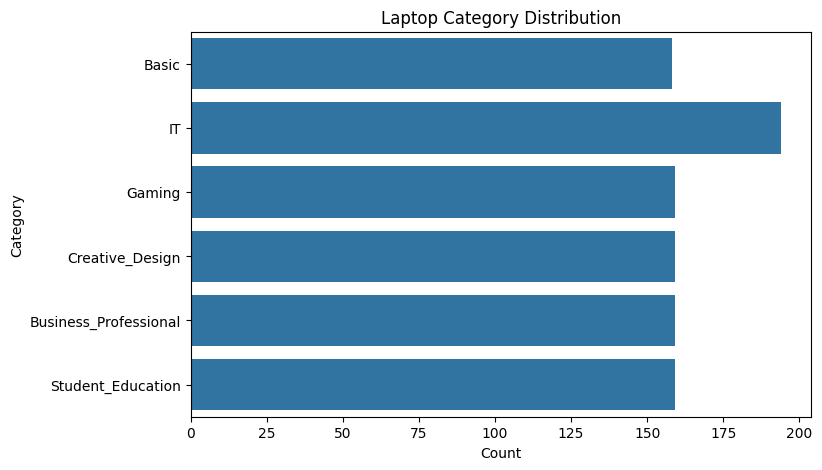

In [ ]:
# Plotting the distribution of categories
plt.figure(figsize=(8,5))
sns.countplot(y='category', data=df)
plt.title('Laptop Category Distribution')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

#### Preprocess the text data

*   Removing punctuation
*   Convert to lowercase
*   Remove extra spaces
*   Tokenize
*   Remove stopwords
*   Perform stemming

In [ ]:
# Combine label and inputsth a preprocessing step
df['category'] = '__label__' + df['category'].astype(str)

stop_words = set(stopwords.words('english'))
# Add necessary stopwords
custom_stopwords = ['tasks', 'task', 'masters, master, bachelor, bachelors',  'advanced']

# Extend the stopwords set with custom stopwords
stop_words.update(custom_stopwords)

def preprocess_with_stemming(text):
    # Remove punctuation and make lowercase
    text = re.sub(r'[^\w\s]', '', text).lower()
    # Remove extra spaces
    text = re.sub(' +', ' ', text)
    # Tokenization
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    # Stemming and join the words back into a string
    stemmed_words = [stemmer.stem(word) for word in word_tokens]
    return ' '.join(stemmed_words)

df['sentence_description'] = df['category'] + ' ' + df['inputs'].map(preprocess_with_stemming)

#### Split data for training and testing - 20%

In [ ]:
# Split data for training and testing
train, test = train_test_split(df, test_size=0.2, random_state=40)

# Save training and testing data to files
train.to_csv("laptop.train", columns=["sentence_description"], index=False, header=False)
test.to_csv("laptop.test", columns=["sentence_description"], index=False, header=False)

#### Train the FastText model

In [ ]:
# Train the FastText model
model = fasttext.train_supervised(input="laptop.train", lr=0.5, epoch=25, wordNgrams=2, minCount=1)

#### Evaluate model performance

In [ ]:
# Evaluate and print model performance
print(model.test("laptop.test"))

(198, 0.8333333333333334, 0.8333333333333334)


#### Confusion matrix and Classification report

Confusion Matrix:
[[32  1  0  0  0  0]
 [ 3 23  0  0  1  1]
 [ 4  1 26  0  4  1]
 [ 0  1  1 22  0  1]
 [ 0  2  0  0 29  2]
 [ 2  4  0  0  4 33]]

Classification Report:
                       precision    recall  f1-score   support

                Basic       0.78      0.97      0.86        33
Business_Professional       0.72      0.82      0.77        28
      Creative_Design       0.96      0.72      0.83        36
               Gaming       1.00      0.88      0.94        25
                   IT       0.76      0.88      0.82        33
    Student_Education       0.87      0.77      0.81        43

             accuracy                           0.83       198
            macro avg       0.85      0.84      0.84       198
         weighted avg       0.85      0.83      0.83       198



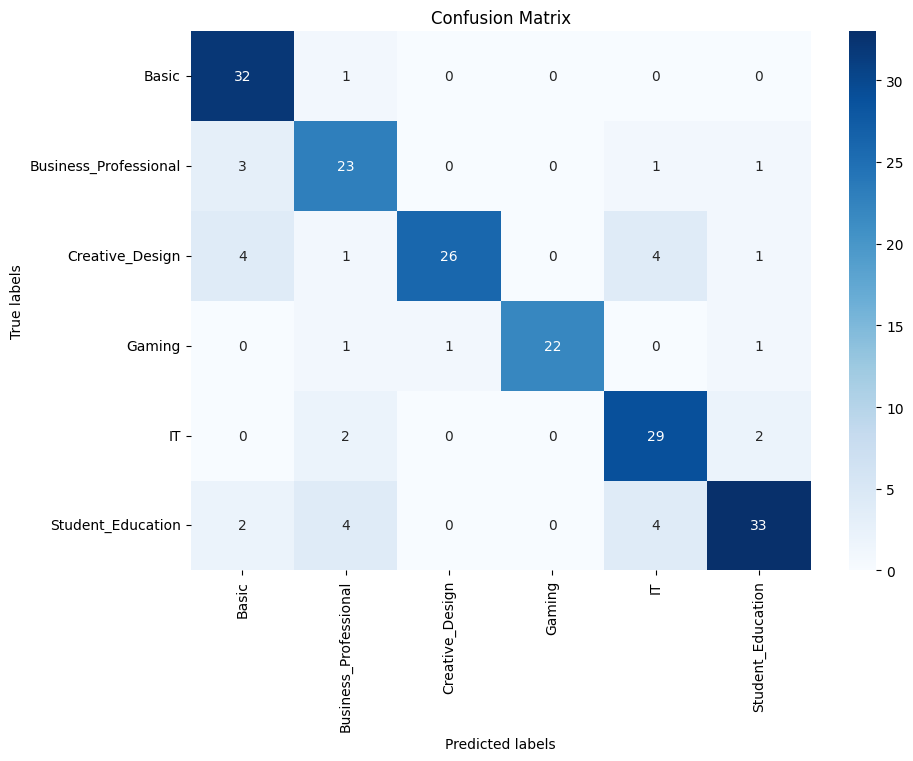

In [ ]:
# Load the test data
test_df = pd.read_csv("laptop.test", names=["sentence_description"])

# Separate the labels and inputs
# test_df[['true_labels', 'inputs']] = test_df['sentence_description'].str.split(' ', 1, expand=True)
# Separate the labels and inputs with correct parameters
test_df[['true_labels', 'inputs']] = test_df['sentence_description'].str.split(' ', n=1, expand=True)

# Preprocess the inputs in the test set
test_df['processed_inputs'] = test_df['inputs'].apply(lambda x: preprocess_with_stemming(x))

# Predict labels for the test set inputs
predictions = test_df['processed_inputs'].apply(lambda sentence: model.predict(sentence)[0][0])

# Since predictions are returned as tuples, extract the first element which is the predicted label
test_df['predicted_labels'] = predictions

# Extract the labels (removing the '__label__' prefix for comparison and reporting)
test_df['true_labels'] = test_df['true_labels'].str.replace('__label__', '')
test_df['predicted_labels'] = test_df['predicted_labels'].str.replace('__label__', '')

# Generate and print the confusion matrix
labels = np.unique(test_df['true_labels'])
conf_matrix = confusion_matrix(test_df['true_labels'], test_df['predicted_labels'], labels=labels)
print("Confusion Matrix:")
print(conf_matrix)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(test_df['true_labels'], test_df['predicted_labels'], labels=labels))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

#### Test with custom inputs

In [ ]:
# function for preprocessing individual inputs
def preprocess_input(input):
    # Preprocess the input
    preprocessed_title = preprocess_with_stemming(input)  # Use the same preprocessing function used for training
    return preprocessed_title

sentences_to_test = [
    "I am a digital artist looking for a laptop that can handle heavy graphic design software.",
    "As a student studying computer science, I need a laptop with great battery life for coding sessions.",
    "I love playing the latest PC games, so I'm searching for a laptop with a high-performance GPU.",
    "Being a freelance writer, I need a lightweight and portable laptop with a comfortable keyboard.",
    "As an engineering student, I require a laptop that can run CAD software smoothly.",
    "I'm a business analyst often working with large datasets, so I need a laptop with plenty of RAM and a fast processor.",
    "As a video editor, I'm in need of a laptop with a high-resolution display and powerful graphics capabilities.",
    "I teach online courses and need a laptop with a high-quality webcam and microphone for lectures.",
    "As a travel blogger, I'm looking for a durable laptop that can handle being on the road.",
    "I am an AI researcher requiring a laptop with advanced computing power for machine learning tasks.",
    "for coding activities"
]

# Predict categories for the inputs
for sentence in sentences_to_test:
    preprocessed_sentence = preprocess_input(sentence)
    prediction = model.predict(preprocessed_sentence)
    print(f"Text: '{sentence}', Predicted Category: {prediction[0][0].replace('__label__', '')}")

Text: 'I am a digital artist looking for a laptop that can handle heavy graphic design software.', Predicted Category: Creative_Design
Text: 'As a student studying computer science, I need a laptop with great battery life for coding sessions.', Predicted Category: Student_Education
Text: 'I love playing the latest PC games, so I'm searching for a laptop with a high-performance GPU.', Predicted Category: Gaming
Text: 'Being a freelance writer, I need a lightweight and portable laptop with a comfortable keyboard.', Predicted Category: Basic
Text: 'As an engineering student, I require a laptop that can run CAD software smoothly.', Predicted Category: Gaming
Text: 'I'm a business analyst often working with large datasets, so I need a laptop with plenty of RAM and a fast processor.', Predicted Category: Gaming
Text: 'As a video editor, I'm in need of a laptop with a high-resolution display and powerful graphics capabilities.', Predicted Category: Creative_Design
Text: 'I teach online course

In [ ]:
# List of inputs to test
inputs_to_test = ["Software Engineer", "Graphic Designer", "Marketing lead",
                      "ml lecturer", "computer science", "event planner",
                      "primary educator", "UX/UI designer", "accounts assistant",
                      "project lead", "intern finance analyst", 'gamer',
                   'I play flight simulator and go to school',
                  'Tutoring students in advanced mathematics',
                  'I need a laptop compatible for both software engineering and gaming',
                  "i need a laptop for spanish lessons and graphic designing",
                  "i need a portable laptop",
                  "computer science student",
                  "for an undergraduate",
                  "for university",
                  "data science undergraduate and gamer"
                  ]


# Predict categories for the inputs
for sentence in inputs_to_test:
    preprocessed_sentence = preprocess_input(sentence)
    prediction = model.predict(preprocessed_sentence)
    print(f"Text: '{sentence}', Predicted Category: {prediction[0][0].replace('__label__', '')}")

Text: 'Software Engineer', Predicted Category: IT
Text: 'Graphic Designer', Predicted Category: Creative_Design
Text: 'Marketing lead', Predicted Category: Business_Professional
Text: 'ml lecturer', Predicted Category: IT
Text: 'computer science', Predicted Category: IT
Text: 'event planner', Predicted Category: Basic
Text: 'primary educator', Predicted Category: Student_Education
Text: 'UX/UI designer', Predicted Category: Creative_Design
Text: 'accounts assistant', Predicted Category: Business_Professional
Text: 'project lead', Predicted Category: IT
Text: 'intern finance analyst', Predicted Category: IT
Text: 'gamer', Predicted Category: Gaming
Text: 'I play flight simulator and go to school', Predicted Category: Gaming
Text: 'Tutoring students in advanced mathematics', Predicted Category: Student_Education
Text: 'I need a laptop compatible for both software engineering and gaming', Predicted Category: Gaming
Text: 'i need a laptop for spanish lessons and graphic designing', Predict

In [ ]:
print(model.predict("Searching for a laptop with a color-accurate display and powerful graphics capabilities for digital art creation.")) # Wrong
print(model.predict("I want a device with a stylus and touch screen for graphic design and photo editing."))

(('__label__Creative_Design',), array([0.49396914]))
(('__label__Creative_Design',), array([0.65365994]))


In [ ]:
print(model.predict("I require a lightweight laptop with robust security features for my business travels."))
print(model.predict("Looking for a device with long battery life to take to school"))

(('__label__Business_Professional',), array([0.3101846]))
(('__label__Student_Education',), array([0.62445176]))


#### Save the trained model

In [ ]:
# model.save_model("input_classification.bin")